# Chapter 3 | Classification

## MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [2]:
X, y = mnist.data, mnist.target

X.shape, y.shape

((70000, 784), (70000,))

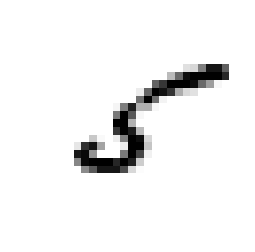

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit_index = 11
some_digit = X[some_digit_index]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

Getting the label associated to the `some_digit` example

In [4]:
y[some_digit_index]

'5'

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], np.array(list(map(int, y[:60000]))), np.array(list(map(int, y[60000:])))

In [6]:
import numpy as np

np.random.seed(3)

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a binary classifer

Let's start by creating a 5-detector as a binary classifier

In [7]:
y_train_5 = (y_train == y[some_digit_index]) # True for all 5s, False for all other digits.
y_test_5 = (y_test == y[some_digit_index])

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=3, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=3, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Mesures

### Cross-Validation

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.9596 , 0.946  , 0.97065])

We're over 95-96 % accuracy. Let's try a dumb classifier to compare.

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [12]:
never5_clf = Never5Classifier()
cross_val_score(never5_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.90885, 0.91085, 0.90925])

### Confusion Matrix

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53184,  1395],
       [ 1080,  4341]], dtype=int64)

### Precision & Recall

In [15]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision Score : {precision_score(y_train_5, y_train_pred):.3f}")
print(f"Recall Score : {recall_score(y_train_5, y_train_pred):.3f}")

Precision Score : 0.757
Recall Score : 0.801


### F1 Score

In [16]:
from sklearn.metrics import f1_score

print(f"F1 Score : {f1_score(y_train_5, y_train_pred):.3f}")

F1 Score : 0.778


### Precision/Recall Tradeoff

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
print(f"Score : {y_scores}")

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

Score : [2267.57177811]
[ True]


In [18]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function", n_jobs=-1)

In [20]:
y_scores.shape

(60000,)

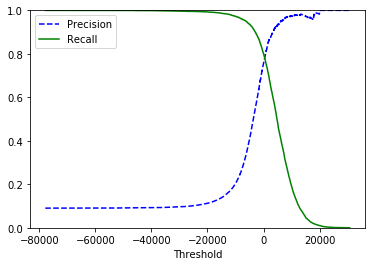

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

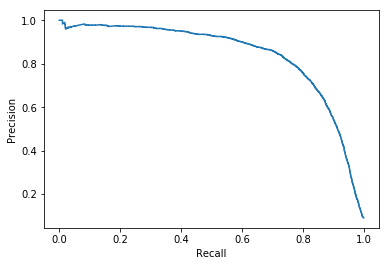

In [22]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [23]:
(y_train_pred == (y_scores > 0)).all()

True

In [24]:
y_train_pred_90 = (y_scores > 1500)

print(f"Precision Score : {precision_score(y_train_5, y_train_pred_90):.3f}")
print(f"Recall Score : {recall_score(y_train_5, y_train_pred_90):.3f}")

Precision Score : 0.845
Recall Score : 0.720


### The ROC Curve

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

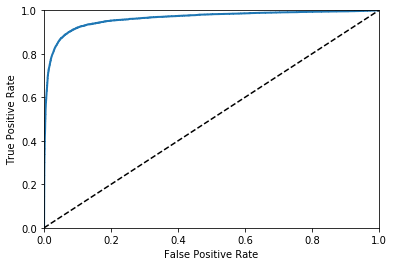

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

Using the ROC AUC (Receiver Operating Characteristic Area Under Curve)

In [27]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9625809688008486

Train a RandomForestClassifier to compare ROC and ROC AUC

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

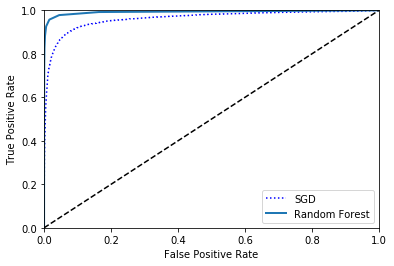

In [29]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [30]:
y_train_pred_90_forest = (y_scores_forest > 0.2)

print(f"ROC AUC Score : {roc_auc_score(y_train_5, y_scores_forest)}")
print(f"Precision Score : {precision_score(y_train_5, y_train_pred_90_forest)}")
print(f"Recall Score : {recall_score(y_train_5, y_train_pred_90_forest)}")

ROC AUC Score : 0.9925785496190273
Precision Score : 0.8579930567035874
Recall Score : 0.957387935805202


## Multiclass Classification

In [31]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=3, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [32]:
print(f"Prediction: {sgd_clf.predict([some_digit])}, Actual: {y[some_digit_index]}")

Prediction: ['8'], Actual: 5


In [33]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-25780.92284506, -11227.40754555,  -3358.51296744,
        -10751.70308304,  -3609.26479602,   2267.57177811,
        -13706.05419725, -18196.52447999,   2302.59482658,
        -11355.97426128]])

In [34]:
print(f"Arg Max: {np.argmax(some_digit_scores)}")
print(sgd_clf.classes_)
print(f"Actual classes: {sgd_clf.classes_[np.argmax(some_digit_scores)]}")

Arg Max: 8
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Actual classes: 8


Evaluate the classifier

In [35]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)

array([0.85932813, 0.88084404, 0.8886833 ])

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.89862028, 0.89434472, 0.90553583])

## Error Analysis

In [37]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5590,    0,   14,    7,    8,   38,   37,    5,  223,    1],
       [   0, 6427,   39,   22,    3,   44,    4,    6,  186,   11],
       [  22,   25, 5256,   86,   68,   22,   67,   40,  364,    8],
       [  29,   23,  109, 5233,    2,  198,   22,   42,  405,   68],
       [  12,   15,   45,    9, 5226,    7,   34,   16,  328,  150],
       [  27,   18,   28,  162,   50, 4445,   74,   17,  535,   65],
       [  29,   19,   47,    2,   41,   85, 5553,    3,  139,    0],
       [  19,   14,   57,   28,   51,   12,    4, 5694,  175,  211],
       [  14,   64,   38,   95,    2,  122,   32,    8, 5432,   44],
       [  22,   21,   28,   55,  114,   36,    1,  179,  379, 5114]],
      dtype=int64)

Since it might be hard to see where the errors are with number, it might be better to visualize them with a graphical representation.

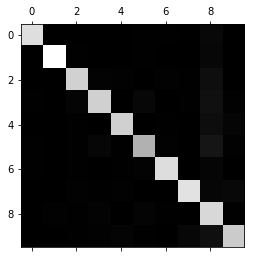

In [38]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [39]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

Normalized representation of the confusion matrix

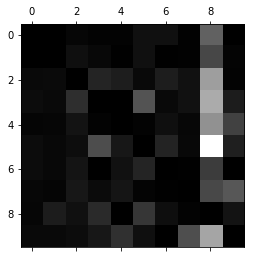

In [40]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Analysing individual errors can be a good way to get insights.

In [41]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

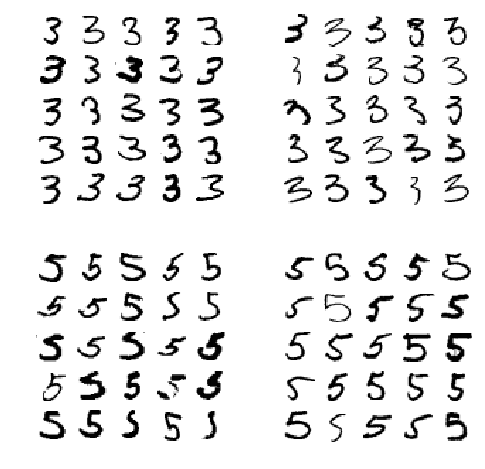

In [42]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [51]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [52]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [53]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3, n_jobs=-1)
f1_score(y_train, y_train_knn_pred, average="macro")

0.9671989524961443

In [54]:
## p. 101 | Multioutput Classification